<a href="https://colab.research.google.com/github/amitpuri/openagi-codes/blob/main/notebooks/Convolutional_Neural_Network_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


Trial 5 Complete [00h 03m 04s]
val_accuracy: 0.984000027179718

Best val_accuracy So Far: 0.984000027179718
Total elapsed time: 00h 10m 54s
Best hyperparameters: {'filters': 64, 'dense_units': 96}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.9933 - loss: 0.0220 - val_accuracy: 0.9861 - val_loss: 0.0527
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9961 - loss: 0.0141 - val_accuracy: 0.9859 - val_loss: 0.0546
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.9974 - loss: 0.0098 - val_accuracy: 0.9852 - val_loss: 0.0576
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9849 - val_loss: 0.0622
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 0.9861 - val_loss: 0.0615
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9778 - loss: 0.0731
Test accuracy: 0.9829999804496765


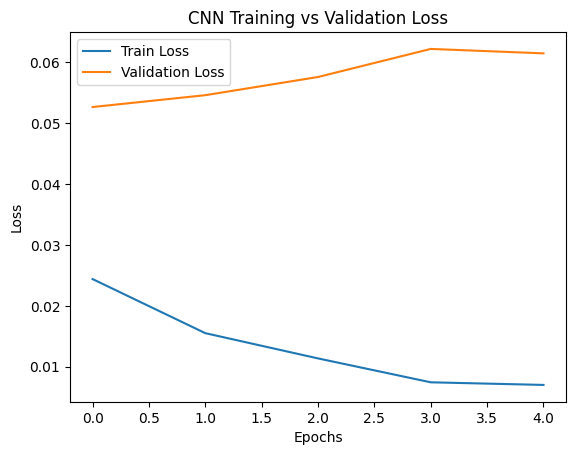

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


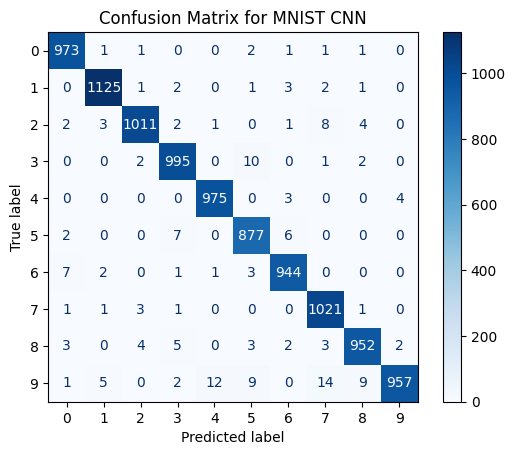

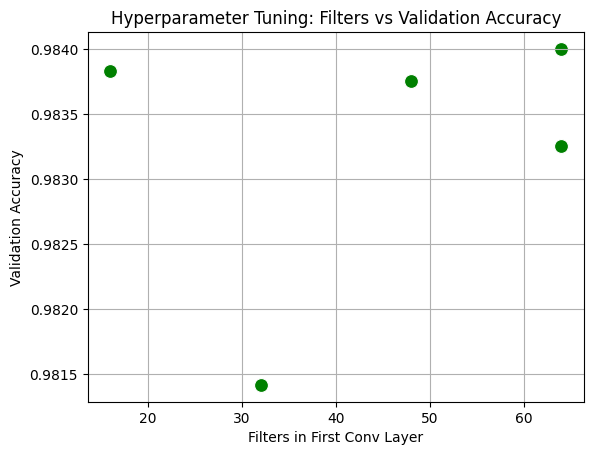

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt

# 1. Load and Pre‑process the Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2. Define a Model Builder for Hyperparameter Tuning
def build_cnn_model(hp):
    model = Sequential()
    # Tune the number of filters in the first Conv2D layer
    filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    model.add(Conv2D(filters, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    # Tune the number of units in the Dense layer
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. Hyperparameter Tuning using Keras Tuner (RandomSearch)
tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='mnist_cnn'
)
tuner.search(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hp.values)

# 4. Train Best Model and Evaluate
history = best_model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.2)
loss, accuracy = best_model.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

# Plot training vs. validation loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training vs Validation Loss')
plt.legend()
plt.show()

# Display confusion matrix
y_pred = best_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST CNN")
plt.show()

# 5. Visualize Hyperparameter Tuning Results
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

filters_list = []
val_acc_list = []
for trial in trials:
    filters_list.append(trial.hyperparameters.get('filters'))
    val_acc_list.append(trial.metrics.get_last_value('val_accuracy'))
plt.figure()
sns.scatterplot(x=filters_list, y=val_acc_list, s=100, color='green')
plt.xlabel("Filters in First Conv Layer")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter Tuning: Filters vs Validation Accuracy")
plt.grid(True)
plt.show()
